АНАЛИЗ ЛОГОВ БЕЗОПАСНОСТИ WINDOWS

1. Загрузка данных...
   Загружено записей: 35
   Уникальные EventID: 5
   Данные нормализованы

2. Анализ подозрительных событий...
   Найдено подозрительных событий: 34
   Процент: 97.1%

3. Создание визуализации...


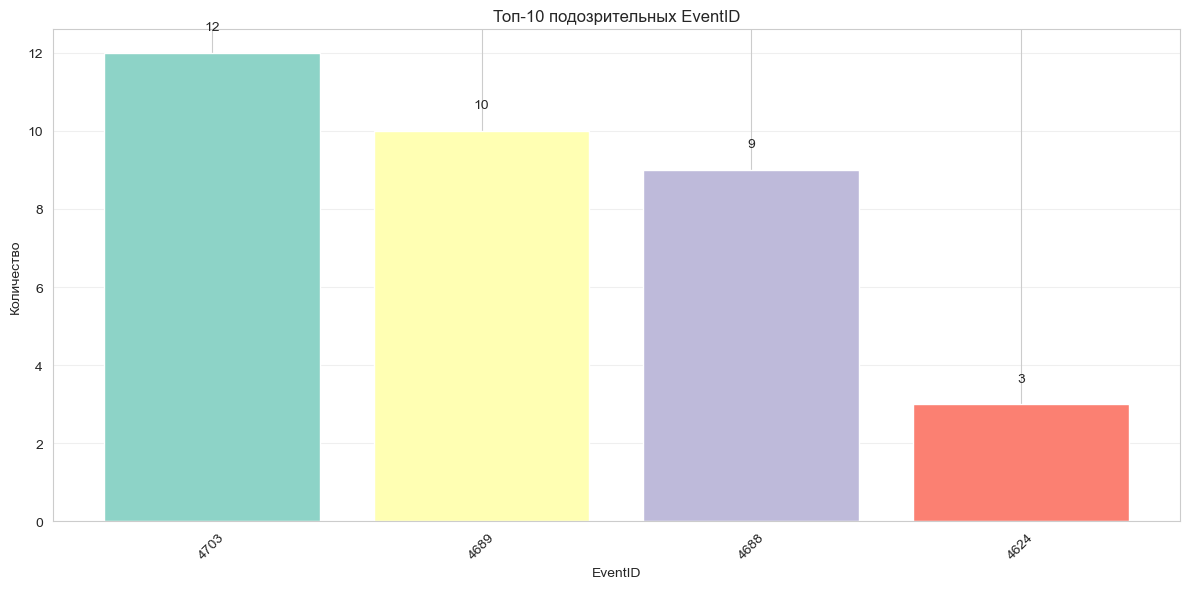

   График сохранен: analysis_results/top10_eventid.png


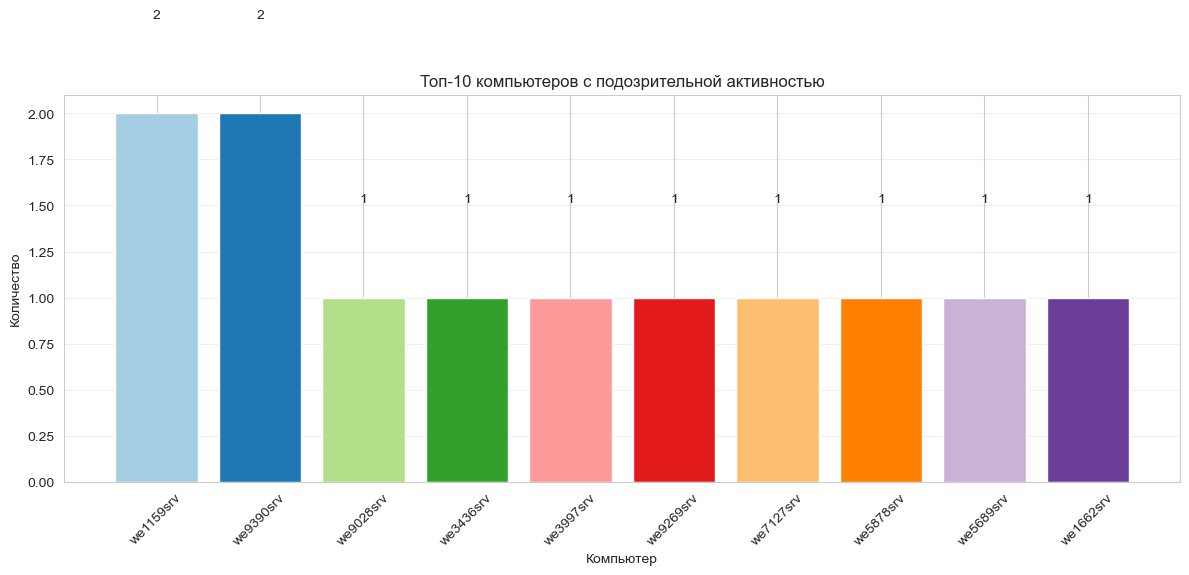

   График сохранен: analysis_results/top10_computers.png


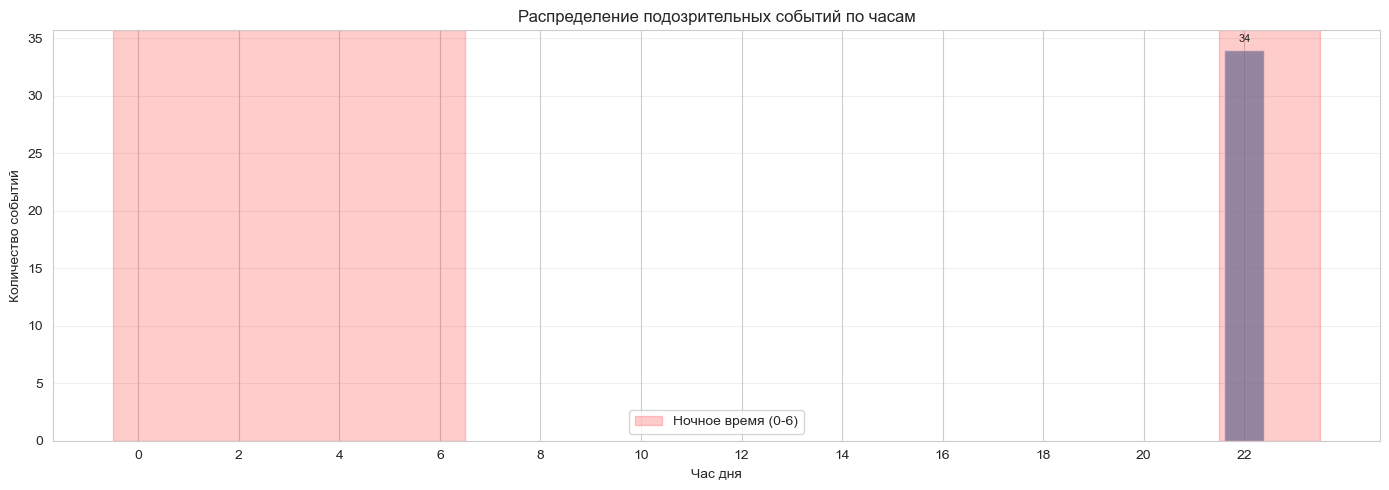

   График сохранен: analysis_results/hourly_distribution.png


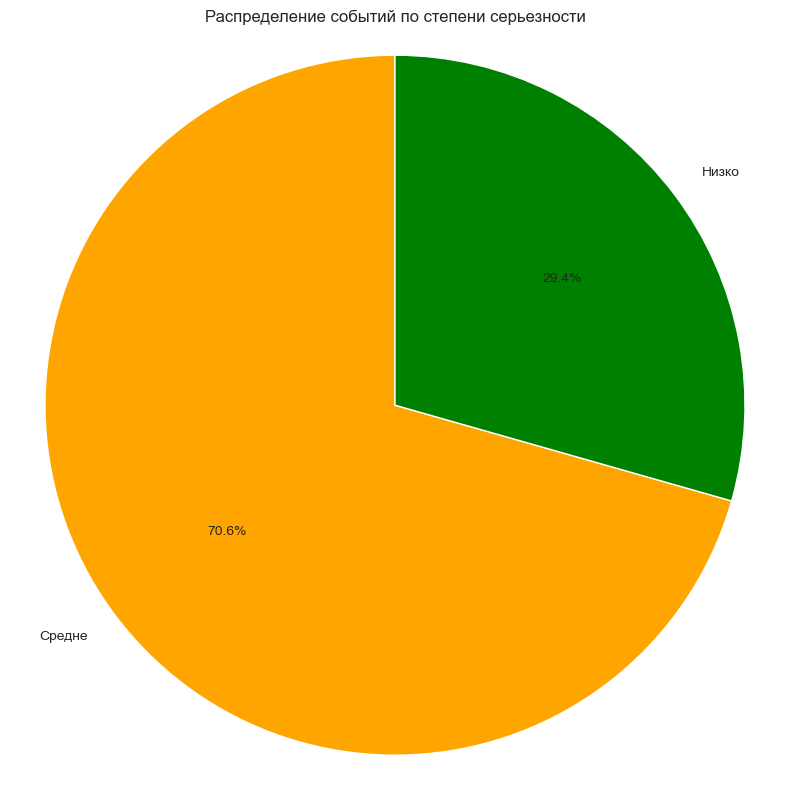

   График сохранен: analysis_results/severity_pie.png

4. Сохранение результатов...
   ✓ suspicious_events.csv - список подозрительных событий
   ✓ summary.txt - статистика
   ✓ top10_eventid.png - график EventID
   ✓ top10_computers.png - график компьютеров
   ✓ hourly_distribution.png - распределение по часам
   ✓ severity_pie.png - распределение по серьезности

✓ Все результаты сохранены в папку: analysis_results/

АНАЛИЗ ЗАВЕРШЕН УСПЕШНО


In [6]:
# Анализ логов безопасности Windows (WinEventLog) - botsv1
# Полное решение домашнего задания

import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
from datetime import datetime

# Настройка стилей
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("=" * 60)
print("АНАЛИЗ ЛОГОВ БЕЗОПАСНОСТИ WINDOWS")
print("=" * 60)

# ============================================================================
# ЭТАП 1. ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ
# ============================================================================

print("\n1. Загрузка данных...")

# Загрузка данных из JSON
with open('botsv1.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# Создание DataFrame
logs = []
for item in data:
    logs.append(item['result'])

df = pd.DataFrame(logs)
print(f"   Загружено записей: {len(df)}")
print(f"   Уникальные EventID: {df['EventCode'].nunique()}")

# Нормализация данных
df['EventCode'] = df['EventCode'].astype(str)
df['ComputerName'] = df['ComputerName'].fillna('Unknown').astype(str)
df['user'] = df['user'].fillna('').astype(str)

# Обработка времени без warnings
df['date_hour'] = pd.to_numeric(df['date_hour'], errors='coerce').fillna(0).astype(int)
df['date_minute'] = pd.to_numeric(df['date_minute'], errors='coerce').fillna(0).astype(int)
df['date_second'] = pd.to_numeric(df['date_second'], errors='coerce').fillna(0).astype(int)
df['date_mday'] = pd.to_numeric(df['date_mday'], errors='coerce').fillna(1).astype(int)

print("   Данные нормализованы")

# ============================================================================
# ЭТАП 2. АНАЛИЗ ПОДОЗРИТЕЛЬНЫХ СОБЫТИЙ
# ============================================================================

print("\n2. Анализ подозрительных событий...")

# Словарь подозрительных EventID
suspicious_event_ids = {
    '4624': 'Успешный вход (сетевой)',
    '4625': 'Неудачный вход',
    '4648': 'Вход с явными данными',
    '4672': 'Спец. привилегии',
    '4688': 'Создание процесса',
    '4689': 'Завершение процесса',
    '4703': 'Изменение прав',
    '4720': 'Создание пользователя',
    '4724': 'Сброс пароля',
    '4732': 'Добавление в группу',
    '1102': 'Очистка журнала',
    '7036': 'Остановка службы'
}

# Функция определения подозрительности
def is_suspicious(row):
    reasons = []
    event_id = row['EventCode']
    
    # Проверка по EventID
    if event_id in suspicious_event_ids:
        reasons.append(suspicious_event_ids[event_id])
    
    # Проверка PowerShell
    if event_id == '4688':
        process = str(row.get('New_Process_Name', '')).lower()
        if 'powershell' in process:
            reasons.append('Запуск PowerShell')
    
    # Проверка нерабочего времени
    hour = row.get('date_hour', 0)
    if hour < 6 or hour > 22:
        reasons.append(f'Ночная активность ({hour}:00)')
    
    return '; '.join(reasons) if reasons else ''

# Применяем анализ
df['Suspicious_Reason'] = df.apply(is_suspicious, axis=1)
suspicious_df = df[df['Suspicious_Reason'] != ''].copy()

print(f"   Найдено подозрительных событий: {len(suspicious_df)}")
print(f"   Процент: {len(suspicious_df)/len(df)*100:.1f}%")

# ============================================================================
# ЭТАП 3. ВИЗУАЛИЗАЦИЯ
# ============================================================================

print("\n3. Создание визуализации...")

# Создаем папку для результатов
output_dir = 'analysis_results'
os.makedirs(output_dir, exist_ok=True)

# ГРАФИК 1: Топ-10 подозрительных EventID
plt.figure(figsize=(12, 6))
top_events = suspicious_df['EventCode'].value_counts().head(10)
colors = plt.cm.Set3(range(len(top_events)))
bars = plt.bar(range(len(top_events)), top_events.values, color=colors)
plt.xticks(range(len(top_events)), top_events.index, rotation=45)
plt.xlabel('EventID')
plt.ylabel('Количество')
plt.title('Топ-10 подозрительных EventID')
plt.grid(axis='y', alpha=0.3)

for i, (bar, count) in enumerate(zip(bars, top_events.values)):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.savefig(f'{output_dir}/top10_eventid.png', dpi=150)
plt.show()
print(f"   График сохранен: {output_dir}/top10_eventid.png")

# ГРАФИК 2: Топ-10 компьютеров
plt.figure(figsize=(12, 6))
top_computers = suspicious_df['ComputerName'].value_counts().head(10)
top_computers.index = [c.split('.')[0] if '.' in str(c) else str(c) for c in top_computers.index]
colors = plt.cm.Paired(range(len(top_computers)))
bars = plt.bar(range(len(top_computers)), top_computers.values, color=colors)
plt.xticks(range(len(top_computers)), top_computers.index, rotation=45)
plt.xlabel('Компьютер')
plt.ylabel('Количество')
plt.title('Топ-10 компьютеров с подозрительной активностью')
plt.grid(axis='y', alpha=0.3)

for i, (bar, count) in enumerate(zip(bars, top_computers.values)):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.savefig(f'{output_dir}/top10_computers.png', dpi=150)
plt.show()
print(f"   График сохранен: {output_dir}/top10_computers.png")

# ГРАФИК 3: Распределение по часам
plt.figure(figsize=(14, 5))
hours = suspicious_df['date_hour'].value_counts().sort_index()
all_hours = pd.Series(0, index=range(24))
for hour, count in hours.items():
    if 0 <= hour <= 23:
        all_hours[hour] = count

bars = plt.bar(all_hours.index, all_hours.values, color='steelblue', alpha=0.7)
plt.axvspan(-0.5, 6.5, alpha=0.2, color='red', label='Ночное время (0-6)')
plt.axvspan(21.5, 23.5, alpha=0.2, color='red')
plt.xlabel('Час дня')
plt.ylabel('Количество событий')
plt.title('Распределение подозрительных событий по часам')
plt.xticks(range(0, 24, 2))
plt.legend()
plt.grid(axis='y', alpha=0.3)

for i, count in enumerate(all_hours.values):
    if count > 0:
        plt.text(i, count + 0.5, str(int(count)), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(f'{output_dir}/hourly_distribution.png', dpi=150)
plt.show()
print(f"   График сохранен: {output_dir}/hourly_distribution.png")

# ГРАФИК 4: Pie chart распределения серьезности
plt.figure(figsize=(8, 8))
severity_counts = suspicious_df['EventCode'].apply(
    lambda x: 'Критично' if x in ['1102', '4724', '4672'] else 
              'Средне' if x in ['4624', '4688', '4703'] else 'Низко'
).value_counts()
colors = {'Критично': 'red', 'Средне': 'orange', 'Низко': 'green'}
plt.pie(severity_counts.values, labels=severity_counts.index, autopct='%1.1f%%',
        colors=[colors.get(s, 'gray') for s in severity_counts.index], startangle=90)
plt.title('Распределение событий по степени серьезности')
plt.axis('equal')
plt.tight_layout()
plt.savefig(f'{output_dir}/severity_pie.png', dpi=150)
plt.show()
print(f"   График сохранен: {output_dir}/severity_pie.png")

# ============================================================================
# СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
# ============================================================================

print("\n4. Сохранение результатов...")

# Сохраняем подозрительные события
suspicious_df[['EventCode', 'ComputerName', 'user', 'date_hour', 'Suspicious_Reason']].to_csv(
    f'{output_dir}/suspicious_events.csv', index=False, encoding='utf-8-sig'
)

# Сохраняем статистику
with open(f'{output_dir}/summary.txt', 'w', encoding='utf-8') as f:
    f.write("РЕЗУЛЬТАТЫ АНАЛИЗА ЛОГОВ\n")
    f.write("=" * 40 + "\n\n")
    f.write(f"Дата анализа: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Всего записей: {len(df)}\n")
    f.write(f"Подозрительных событий: {len(suspicious_df)}\n")
    f.write(f"Процент: {len(suspicious_df)/len(df)*100:.1f}%\n\n")
    
    f.write("ТОП-10 ПОДОЗРИТЕЛЬНЫХ EVENTID:\n")
    for event, count in top_events.items():
        desc = suspicious_event_ids.get(event, 'Неизвестное')
        f.write(f"  {event} ({desc}): {count}\n")
    
    f.write("\nТОП-10 КОМПЬЮТЕРОВ:\n")
    for comp, count in suspicious_df['ComputerName'].value_counts().head(10).items():
        short = comp.split('.')[0] if '.' in str(comp) else str(comp)
        f.write(f"  {short}: {count}\n")
    
    f.write("\nРАСПРЕДЕЛЕНИЕ ПО ЧАСАМ:\n")
    for hour in range(24):
        count = all_hours.get(hour, 0)
        if count > 0:
            f.write(f"  {hour:02d}:00 - {int(count)} событий\n")

print(f"   ✓ suspicious_events.csv - список подозрительных событий")
print(f"   ✓ summary.txt - статистика")
print(f"   ✓ top10_eventid.png - график EventID")
print(f"   ✓ top10_computers.png - график компьютеров")
print(f"   ✓ hourly_distribution.png - распределение по часам")
print(f"   ✓ severity_pie.png - распределение по серьезности")

print(f"\n✓ Все результаты сохранены в папку: {output_dir}/")
print("\n" + "=" * 60)
print("АНАЛИЗ ЗАВЕРШЕН УСПЕШНО")
print("=" * 60)